## Optimizers

1. **Objective**: Research and investigate to compare the performance of `Adam
(Adaptive Moment Estimation)`, `RMSprop (Root Mean Square Prop)`, and
`AdamW (Adam with Weight Decay)` optimizers on a feedforward fully
connected neural network using the KMNIST dataset.
1. **Importance**: Understanding the strengths and weaknesses of different
optimization algorithms helps in selecting the right one for specific tasks in
deep learning

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import time
plt.style.use('dark_background')
dash_lines = "-"*80

!pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 7.0 MB/s eta 0:00:00


## Notebook Guide
1. Github load latest files - `git clone`
1. Initialize `constants`
1. Grid/Randomized Search on Optimizer's params
1. Train - `NN` on Best `Optimizer params*`
1. Test - `NN` on Hold-out Testset
1. Save `model` & `results`

## Step 1. Github sync

In [ ]:
# #Github clone
# !git clone https://github.com/iamkevinxavier/humber-AdvDL-midterm.git

## Load Preprocessed Data
1. Standarized
1. train/val/test : 60/10/10

In [ ]:
# #Load KMNIST preprocessed data from folder
# file_path = 'humber-AdvDL-midterm/Dataset/kmnist_preprocessed.zip'
# extract_to = './KMNIST_Dataset'
# with zipfile.ZipFile(file_path, 'r') as zip_ref:
#   zip_ref.extractall(extract_to)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamkevinxavier/kmnist-standardized")

print("Path to dataset files:", path)

In [10]:
extract_to = path
train_file_path = os.path.join(extract_to, 'kmnist_train_preprocessed.npz')
val_file_path = os.path.join(extract_to, 'kmnist_val_preprocessed.npz')
test_file_path = os.path.join(extract_to, 'kmnist_test_preprocessed.npz')

## Step 2. Model Architecture

In [11]:
class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet, self).__init__()
    self.fc1 = nn.Flatten()
    self.fc2 = nn.Linear(784, 128, dtype=torch.float64)
    self.fc3 = nn.ReLU()
    self.fc4 = nn.Linear(128, 64, dtype=torch.float64)
    self.fc5 = nn.ReLU()
    self.fc6 = nn.Linear(64, 10, dtype=torch.float64)
    self.fc7 = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = self.fc4(x)
    x = self.fc5(x)
    x = self.fc6(x)
    x = self.fc7(x)
    return x

model_nn = NeuralNet()

In [12]:
#constant params*
learning_rate = 1e-3
batch_size = 64
num_epochs = 21
lossfunc = nn.CrossEntropyLoss()

#grid search params*
n_iter = 10
cv = 5

## Step 3. Grid Search for Optimizers Parameters

In [13]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from skorch import NeuralNetClassifier

### define params*

In [14]:
param_grid = {
    'optimizer__lr': [1e-2, 1e-3, 1e-4],  # Learning rate
    'optimizer__alpha': [0.9, 0.99],  # Smoothing constant (decay rate)
    'optimizer__eps': [1e-8, 1e-7],  # Small value to prevent division by zero
    'optimizer__weight_decay': [0, 1e-4, 1e-2],  # L2 regularization strength
    'optimizer__momentum': [0, 0.9]  # Momentum for RMSprop
}

In [15]:
def load_data():
  train_data = np.load(train_file_path)
  val_data = np.load(val_file_path)
  X = np.concatenate([train_data['images'], val_data['images']], axis=0)
  y = np.concatenate([train_data['labels'], val_data['labels']], axis=0)
  X = torch.tensor(X, dtype=torch.float64)
  y = torch.tensor(y, dtype=torch.long)
  print("Train images: ", X.shape)
  print("Train label: ", y.shape)
  return X, y

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from skorch import NeuralNetClassifier
from sklearn.model_selection import RandomizedSearchCV

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

# Wrapper to skorch nn for compatibility with scikit API using RMSprop
model = NeuralNetClassifier(
    module=NeuralNet,  # Your custom neural network module
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.RMSprop,  # Change to RMSprop optimizer
    max_epochs=num_epochs,
    batch_size=batch_size,
    device=device,
    verbose=False
)

# Initializing the search with RandomizedSearchCV
grid = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_jobs=2,
    n_iter=n_iter,
    cv=cv  # KFold cross-validation
)

# Load your data
X, y = load_data()

# Start timing the fit process
start_time = time.time()

# Fit the model using randomized search
grid_result = grid.fit(X, y)

# End timing the process
end_time = time.time()
print(f'Training Time: {end_time - start_time:.2f} seconds')

# Summarize the results
print(f"Random Search -> cv: {cv}, epochs: {num_epochs}, batch_size: {batch_size}")
dash_lines = '-' * 60
print(dash_lines)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print(dash_lines)

# Print mean, std, and params for each combination of parameters
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Device: cpu
Train images:  torch.Size([60000, 28, 28])
Train label:  torch.Size([60000])
Training Time: 3507.39 seconds
Random Search -> cv: 5, epochs: 21, batch_size: 64
------------------------------------------------------------
Best: 0.939283 using {'optimizer__weight_decay': 0, 'optimizer__momentum': 0, 'optimizer__lr': 0.001, 'optimizer__eps': 1e-08, 'optimizer__alpha': 0.99}
------------------------------------------------------------
0.936400 (0.002382) with: {'optimizer__weight_decay': 0, 'optimizer__momentum': 0, 'optimizer__lr': 0.001, 'optimizer__eps': 1e-07, 'optimizer__alpha': 0.9}
0.936417 (0.001575) with: {'optimizer__weight_decay': 0.0001, 'optimizer__momentum': 0.9, 'optimizer__lr': 0.0001, 'optimizer__eps': 1e-08, 'optimizer__alpha': 0.9}
0.651367 (0.110818) with: {'optimizer__weight_decay': 0, 'optimizer__momentum': 0, 'optimizer__lr': 0.01, 'optimizer__eps': 1e-07, 'optimizer__alpha': 0.9}
0.933683 (0.011839) with: {'optimizer__weight_decay': 0.0001, 'optimizer__mo

In [17]:
#store grid search results in DataFrame
results_df = pd.DataFrame(grid_result.cv_results_)
results_df = pd.concat([pd.DataFrame(results_df['params'].tolist()),
                        results_df[['mean_test_score', 'std_test_score']]], axis=1)
print(results_df)
results_df.to_csv(f'rms_prop_grid_search_results.csv', index=True, header=True)

   optimizer__weight_decay  optimizer__momentum  optimizer__lr  \
0                   0.0000                  0.0         0.0010   
1                   0.0001                  0.9         0.0001   
2                   0.0000                  0.0         0.0100   
3                   0.0001                  0.0         0.0010   
4                   0.0100                  0.0         0.0100   
5                   0.0001                  0.9         0.0001   
6                   0.0001                  0.9         0.0100   
7                   0.0100                  0.9         0.0100   
8                   0.0100                  0.0         0.0001   
9                   0.0000                  0.0         0.0010   

   optimizer__eps  optimizer__alpha  mean_test_score  std_test_score  
0    1.000000e-07              0.90         0.936400        0.002382  
1    1.000000e-08              0.90         0.936417        0.001575  
2    1.000000e-07              0.90         0.651367        

# Step 4. Train `NN` on `Best Parameters`

## K-Fold

In [18]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset
from torch.utils.data import Dataset

### set best params*

In [19]:
optimizer = optim.RMSprop(
    params=model_nn.parameters(),
    lr=grid_result.best_params_['optimizer__lr'],  # Best learning rate
    weight_decay=grid_result.best_params_['optimizer__weight_decay'],  # Best weight decay (L2 regularization)
    alpha=grid_result.best_params_['optimizer__alpha'],  # Best alpha (smoothing constant)
    eps=grid_result.best_params_['optimizer__eps'],  # Best epsilon (small constant)
    momentum=grid_result.best_params_['optimizer__momentum']  # Best momentum
)


In [20]:
#Load npz files - alter way
class NPZDataset(Dataset):
    def __init__(self, npz_file):
        data = np.load(npz_file)
        self.images = data['images']
        self.labels = data['labels']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

#load data
train_data = NPZDataset(train_file_path)
val_data = NPZDataset(val_file_path)
test_data = NPZDataset(test_file_path)

#batch loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, shuffle=False)
test_loader = DataLoader(test_data, shuffle=False)

#Train + Validation sets
dataset = train_data + val_data
print(len(dataset))

60000


In [21]:
def model_training_loop(kfold:int, model, train_loader:DataLoader, val_loader:DataLoader):
  #Training loop
  losses = torch.zeros(num_epochs)
  trainAcc = []
  valAcc = []
  trainTime = []

  print(f"K-Fold: {kfold}")
  print(f"Train Batches: {len(train_loader):>6}", f"Validation Batches: {len(val_loader):>6}")
  print(dash_lines)

  #epochs
  for epoch in range(num_epochs):
    batchLoss=[]
    batchtrainAcc=[]
    batchvalAcc=[]

    #training
    start_time = time.time()
    model.to(device)
    model.train()
    for batch_idx, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)

      #forwardpass
      ypred = model(images)
      #loss
      loss = lossfunc(ypred, labels)

      #backpass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #storing results
      batchLoss.append(loss.item())
      ypred = ypred.cpu()
      labels = labels.cpu()

      # Compute batch accuracy
      acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == labels).float())
      batchtrainAcc.append(acc)

    end_time = time.time()
    trainTime.append(end_time - start_time)
    # End of batch loop
    # Compute average training accuracy and loss for this epoch
    trainAcc.append(np.mean(batchtrainAcc))
    losses[epoch] = np.mean(batchLoss)

    #evaluate on validation set
    model.eval()
    for batch_idx, (X, y) in enumerate(val_loader):
      X = X.to(device)
      y = y.to(device)

      with torch.no_grad():
        ypred = model(X)
        ypred = ypred.cpu()
        y = y.cpu()

        # Compute test accuracy
        batchvalAcc.append(100 * torch.mean((torch.argmax(ypred, dim=1) == y).float()))

    valAcc.append(np.mean(batchvalAcc))

    # Print epoch statistics
    print(f'Epoch: {epoch+1:>3}/{num_epochs}, Loss: {loss.item():>6.2f}, Train Accuracy: {trainAcc[-1]:>6.2f}, Validation Accuracy: {valAcc[-1]:>6.2f}')
  print(f'Training Time: {np.sum(trainTime):.2f} seconds')
  print(dash_lines)

  return np.mean(losses.cpu().numpy()), np.mean(trainAcc), np.mean(valAcc), np.sum(trainTime)

In [22]:
## Testing
def model_testing(model, test_loader:DataLoader):
  model.eval()
  with torch.no_grad():
    testAcc = []
    for X, y in test_loader:
      X = X.to(device)
      y = y.to(device)
      ypred = model(X)
      ypred = ypred.cpu()
      y = y.cpu()
      acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
      testAcc.append(acc)
  return np.mean(testAcc)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_nn.to(device)

NeuralNet(
  (fc1): Flatten(start_dim=1, end_dim=-1)
  (fc2): Linear(in_features=784, out_features=128, bias=True)
  (fc3): ReLU()
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): ReLU()
  (fc6): Linear(in_features=64, out_features=10, bias=True)
  (fc7): Softmax(dim=1)
)

### KFold iter

In [24]:
#KFold
kf = KFold(n_splits=cv, shuffle=True, random_state=42)
results = pd.DataFrame(columns=['loss', 'trainAcc', 'valAcc', 'trainTime'])

#K iter
for fold, (train_index, val_index) in enumerate(kf.split(dataset)):
    print("Train:", len(train_index), "Test:", len(val_index))

    #Subset
    train_dataset = Subset(dataset, train_index)
    val_dataset = Subset(dataset, val_index)

    #Dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    #pass to training loop
    loss, trainAcc, valAcc, Traintime = model_training_loop(fold, model_nn, train_loader, val_loader)

    #results
    results.loc[fold] = [loss, trainAcc, valAcc, Traintime]

Train: 48000 Test: 12000
K-Fold: 0
Train Batches:    750 Validation Batches:    188
------------------------------------------------------------
Epoch:   1/21, Loss:   1.55, Train Accuracy:  85.96, Validation Accuracy:  90.08
Epoch:   2/21, Loss:   1.56, Train Accuracy:  91.85, Validation Accuracy:  92.17
Epoch:   3/21, Loss:   1.60, Train Accuracy:  93.38, Validation Accuracy:  92.17
Epoch:   4/21, Loss:   1.54, Train Accuracy:  94.36, Validation Accuracy:  93.11
Epoch:   5/21, Loss:   1.52, Train Accuracy:  94.83, Validation Accuracy:  93.58
Epoch:   6/21, Loss:   1.56, Train Accuracy:  95.32, Validation Accuracy:  93.63
Epoch:   7/21, Loss:   1.49, Train Accuracy:  95.64, Validation Accuracy:  93.54
Epoch:   8/21, Loss:   1.51, Train Accuracy:  95.92, Validation Accuracy:  93.83
Epoch:   9/21, Loss:   1.49, Train Accuracy:  96.21, Validation Accuracy:  93.63
Epoch:  10/21, Loss:   1.51, Train Accuracy:  96.37, Validation Accuracy:  93.90
Epoch:  11/21, Loss:   1.49, Train Accuracy: 

In [25]:
#KFold Results
display(results)

,loss,trainAcc,valAcc,trainTime
0,1.505919,95.610123,93.457924,81.046772
1,1.488614,97.254967,96.708778,77.338516
2,1.484931,97.621323,97.513771,73.770674
3,1.482511,97.859436,97.650307,74.658909
4,1.481297,97.983734,97.689095,74.430722


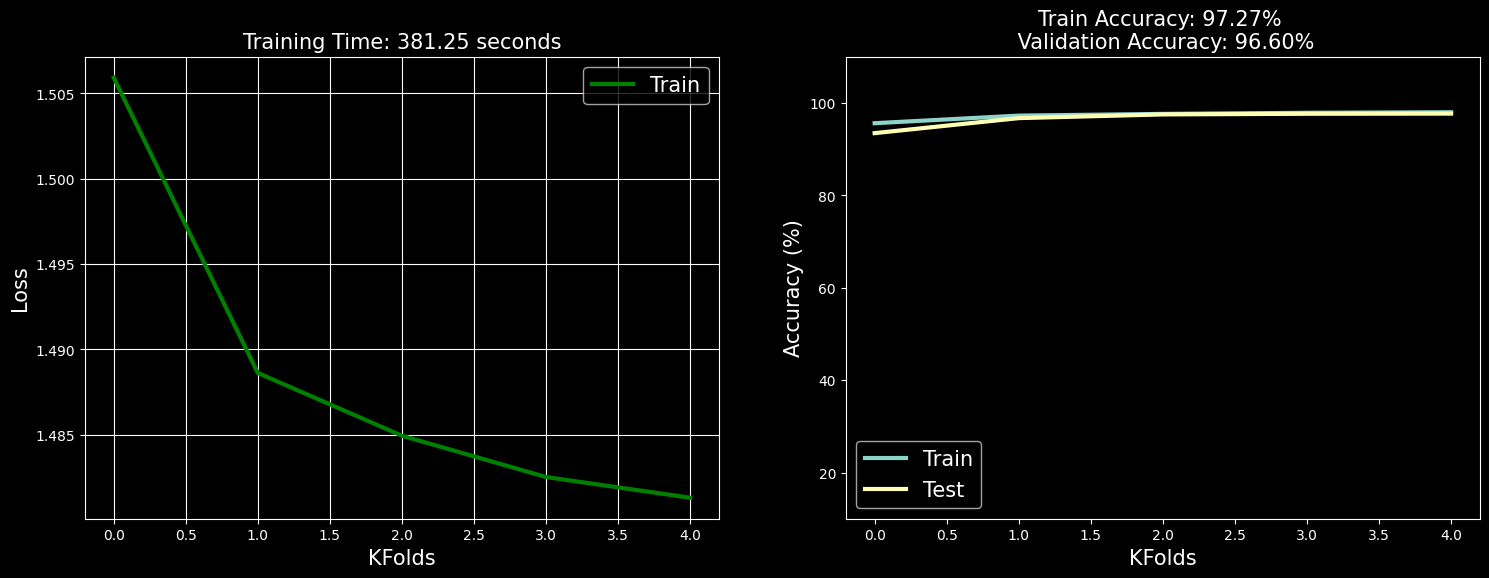

In [26]:
#Visualize
fig,ax = plt.subplots(1, 2,figsize=(18,6))

ax[0].plot(results['loss'], 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('KFolds', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title(f'Training Time: {results["trainTime"].sum():.2f} seconds', fontsize = 15)
ax[0].grid(True)

ax[1].plot(results['trainAcc'], label ='Train', lw = 3)
ax[1].plot(results['valAcc'], label ='Test', lw = 3)
ax[1].set_xlabel('KFolds', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {results["trainAcc"].mean():.2f}% \n Validation Accuracy: {results["valAcc"].mean():.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

## Final Test

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd /content/drive/MyDrive/Advanced deep learning

/content/drive/MyDrive/Advanced deep learning


In [27]:
print(f"Test Samples: {len(test_loader)}")

Test Samples: 10000


In [28]:
testAcc = model_testing(model_nn, test_loader)
print(f'Testset Accuracy: {testAcc:.2f}%')
print(dash_lines)

Testset Accuracy: 88.05%
------------------------------------------------------------


## Save `NN`

In [29]:
# Save the model
torch.save(model_nn.state_dict(), 'Kmnist_model_rmsprop.pth')

# Extra --

In [ ]:
#NN Model Architecture - Japanise Symbols classification task
model_seq_nn = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128, dtype=torch.float64),
    nn.ReLU(),
    nn.Linear(128, 64,  dtype=torch.float64),
    nn.ReLU(),
    nn.Linear(64, 10,  dtype=torch.float64),
    nn.Softmax(dim=1)
)

#display
model_seq_nn

In [ ]:
#Optimizer tunable*
optimizer = optim.Adam(model_seq_nn.parameters(), lr=learning_rate)

In [ ]:
#Training loop
losses = torch.zeros(num_epochs)
trainAcc = []
valAcc = []
trainTime = []

for epoch in range(num_epochs):
  batchLoss=[]
  batchtrainAcc=[]
  batchvalAcc=[]

  #training
  start_time = time.time()
  model.train()
  for batch_idx, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    #forwardpass
    ypred = model(images)
    #loss
    loss = lossfunc(ypred, labels)

    #backpass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #storing results
    batchLoss.append(loss.item())
    ypred = ypred.cpu()
    labels = labels.cpu()

    # Compute batch accuracy
    acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == labels).float())
    batchtrainAcc.append(acc)

  end_time = time.time()
  trainTime.append(end_time - start_time)
  # End of batch loop
  # Compute average training accuracy and loss for this epoch
  trainAcc.append(np.mean(batchtrainAcc))
  losses[epoch] = np.mean(batchLoss)

  #evaluate on validation set
  model.eval()
  for batch_idx, (X, y) in enumerate(val_loader):
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad():
      ypred = model(X)
      ypred = ypred.cpu()
      y = y.cpu()

      # Compute test accuracy
      batchvalAcc.append(100 * torch.mean((torch.argmax(ypred, dim=1) == y).float()))

  valAcc.append(np.mean(batchvalAcc))

  # Print epoch statistics
  print(f'Epoch: {epoch+1:>3}/{num_epochs}, Loss: {loss.item():>6.2f}, Train Accuracy: {trainAcc[-1]:>6.2f}, Validation Accuracy: {valAcc[-1]:>6.2f}')

print(f'Training Time: {np.sum(trainTime):.2f} seconds')

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(valAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Validation Accuracy: {valAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()